# Using the Forward-Forward Algorithm for Image Classification

**Author:** [Suvaditya Mukherjee](https://twitter.com/halcyonrayes)<br>
**Date created:** 2023/01/08<br>
**Last modified:** 2023/01/08<br>
**Description:** Training a Dense-layer model using the Forward-Forward algorithm.

## Introduction

The following example explores how to use the Forward-Forward algorithm to perform
training instead of the traditionally-used method of backpropagation, as proposed by
Hinton in
[The Forward-Forward Algorithm: Some Preliminary Investigations](https://www.cs.toronto.edu/~hinton/FFA13.pdf)
(2022).

The concept was inspired by the understanding behind
[Boltzmann Machines](http://www.cs.toronto.edu/~fritz/absps/dbm.pdf). Backpropagation
involves calculating the difference between actual and predicted output via a cost
function to adjust network weights. On the other hand, the FF Algorithm suggests the
analogy of neurons which get "excited" based on looking at a certain recognized
combination of an image and its correct corresponding label.

This method takes certain inspiration from the biological learning process that occurs in
the cortex. A significant advantage that this method brings is the fact that
backpropagation through the network does not need to be performed anymore, and that
weight updates are local to the layer itself.

As this is yet still an experimental method, it does not yield state-of-the-art results.
But with proper tuning, it is supposed to come close to the same.
Through this example, we will examine a process that allows us to implement the
Forward-Forward algorithm within the layers themselves, instead of the traditional method
of relying on the global loss functions and optimizers.

The tutorial is structured as follows:

- Perform necessary imports
- Load the [MNIST dataset](http://yann.lecun.com/exdb/mnist/)
- Visualize Random samples from the MNIST dataset
- Define a `FFDense` Layer to override `call` and implement a custom `forwardforward`
method which performs weight updates.
- Define a `FFNetwork` Layer to override `train_step`, `predict` and implement 2 custom
functions for per-sample prediction and overlaying labels
- Convert MNIST from `NumPy` arrays to `tf.data.Dataset`
- Fit the network
- Visualize results
- Perform inference on test samples

As this example requires the customization of certain core functions with
`keras.layers.Layer` and `keras.models.Model`, refer to the following resources for
a primer on how to do so:

- [Customizing what happens in `model.fit()`](https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit)
- [Making new Layers and Models via subclassing](https://www.tensorflow.org/guide/keras/custom_layers_and_models)

## Setup imports

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import random
from tensorflow.compiler.tf2xla.python import xla

## Load the dataset and visualize the data

We use the `keras.datasets.mnist.load_data()` utility to directly pull the MNIST dataset
in the form of `NumPy` arrays. We then arrange it in the form of the train and test
splits.

Following loading the dataset, we select 4 random samples from within the training set
and visualize them using `matplotlib.pyplot`.

4 Random Training samples and labels


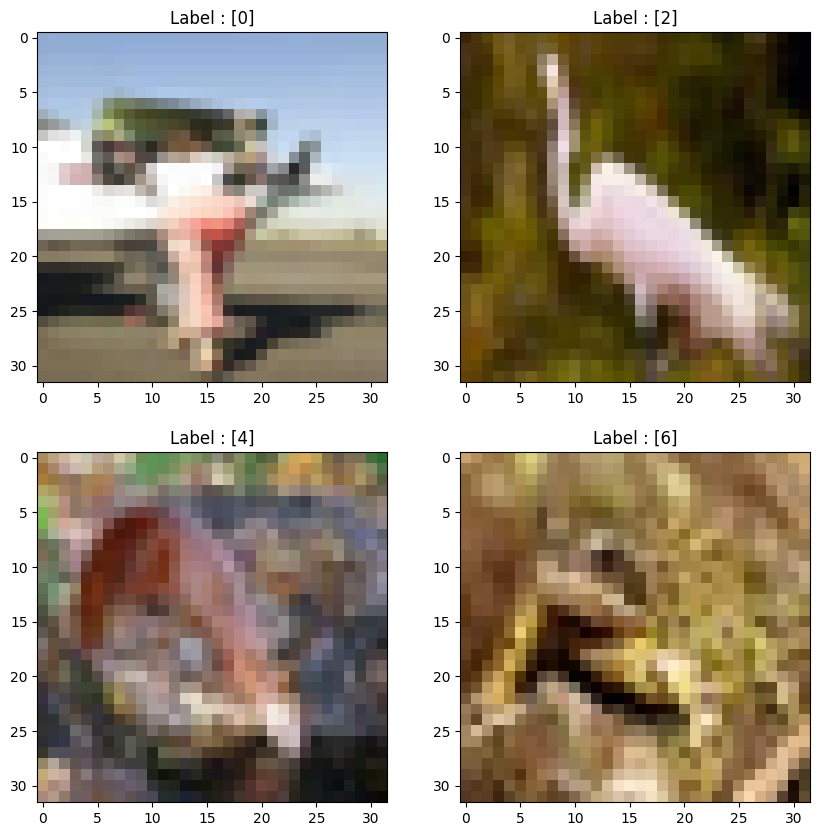

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()



print("4 Random Training samples and labels")
idx1, idx2, idx3, idx4 = random.sample(range(0, x_train.shape[0]), 4)

img1 = (x_train[idx1], y_train[idx1])
img2 = (x_train[idx2], y_train[idx2])
img3 = (x_train[idx3], y_train[idx3])
img4 = (x_train[idx4], y_train[idx4])

imgs = [img1, img2, img3, img4]

plt.figure(figsize=(10, 10))

for idx, item in enumerate(imgs):
    image, label = item[0], item[1]
    plt.subplot(2, 2, idx + 1)
    plt.imshow(image, cmap="gray")
    plt.title(f"Label : {label}")
plt.show()

## Define `FFDense` custom layer

In this custom layer, we have a base `keras.layers.Dense` object which acts as the
base `Dense` layer within. Since weight updates will happen within the layer itself, we
add an `keras.optimizers.Optimizer` object that is accepted from the user. Here, we
use `Adam` as our optimizer with a rather higher learning rate of `0.03`.

Following the algorithm's specifics, we must set a `threshold` parameter that will be
used to make the positive-negative decision in each prediction. This is set to a default
of 2.0.
As the epochs are localized to the layer itself, we also set a `num_epochs` parameter
(defaults to 50).

We override the `call` method in order to perform a normalization over the complete
input space followed by running it through the base `Dense` layer as would happen in a
normal `Dense` layer call.

We implement the Forward-Forward algorithm which accepts 2 kinds of input tensors, each
representing the positive and negative samples respectively. We write a custom training
loop here with the use of `tf.GradientTape()`, within which we calculate a loss per
sample by taking the distance of the prediction from the threshold to understand the
error and taking its mean to get a `mean_loss` metric.

With the help of `tf.GradientTape()` we calculate the gradient updates for the trainable
base `Dense` layer and apply them using the layer's local optimizer.

Finally, we return the `call` result as the `Dense` results of the positive and negative
samples while also returning the last `mean_loss` metric and all the loss values over a
certain all-epoch run.

In [3]:

class FFDense(keras.layers.Layer):
    """
    A custom ForwardForward-enabled Dense layer. It has an implementation of the
    Forward-Forward network internally for use.
    This layer must be used in conjunction with the `FFNetwork` model.
    """

    def __init__(
        self,
        units,
        optimizer,
        loss_metric,
        num_epochs=50,
        use_bias=True,
        kernel_initializer="glorot_uniform",
        bias_initializer="zeros",
        kernel_regularizer=None,
        bias_regularizer=None,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.dense = keras.layers.Dense(
            units=units,
            use_bias=use_bias,
            kernel_initializer=kernel_initializer,
            bias_initializer=bias_initializer,
            kernel_regularizer=kernel_regularizer,
            bias_regularizer=bias_regularizer,
        )
        self.relu = keras.layers.ReLU()
        self.optimizer = optimizer
        self.loss_metric = loss_metric
        self.threshold = 1.5
        self.num_epochs = num_epochs

    # We perform a normalization step before we run the input through the Dense
    # layer.

    def call(self, x):
        x_norm = tf.norm(x, ord=2, axis=1, keepdims=True)
        x_norm = x_norm + 1e-4
        x_dir = x / x_norm
        res = self.dense(x_dir)
        return self.relu(res)

    # The Forward-Forward algorithm is below. We first perform the Dense-layer
    # operation and then get a Mean Square value for all positive and negative
    # samples respectively.
    # The custom loss function finds the distance between the Mean-squared
    # result and the threshold value we set (a hyperparameter) that will define
    # whether the prediction is positive or negative in nature. Once the loss is
    # calculated, we get a mean across the entire batch combined and perform a
    # gradient calculation and optimization step. This does not technically
    # qualify as backpropagation since there is no gradient being
    # sent to any previous layer and is completely local in nature.

    def forward_forward(self, x_pos, x_neg):
        for i in range(self.num_epochs):
            with tf.GradientTape() as tape:
                g_pos = tf.math.reduce_mean(tf.math.pow(self.call(x_pos), 2), 1)
                g_neg = tf.math.reduce_mean(tf.math.pow(self.call(x_neg), 2), 1)

                loss = tf.math.log(
                    1
                    + tf.math.exp(
                        tf.concat([-g_pos + self.threshold, g_neg - self.threshold], 0)
                    )
                )
                mean_loss = tf.cast(tf.math.reduce_mean(loss), tf.float32)
                self.loss_metric.update_state([mean_loss])
            gradients = tape.gradient(mean_loss, self.dense.trainable_weights)
            self.optimizer.apply_gradients(zip(gradients, self.dense.trainable_weights))
        return (
            tf.stop_gradient(self.call(x_pos)),
            tf.stop_gradient(self.call(x_neg)),
            self.loss_metric.result(),
        )


## Define the `FFNetwork` Custom Model

With our custom layer defined, we also need to override the `train_step` method and
define a custom `keras.models.Model` that works with our `FFDense` layer.

For this algorithm, we must 'embed' the labels onto the original image. To do so, we
exploit the structure of MNIST images where the top-left 10 pixels are always zeros. We
use that as a label space in order to visually one-hot-encode the labels within the image
itself. This action is performed by the `overlay_y_on_x` function.

We break down the prediction function with a per-sample prediction function which is then
called over the entire test set by the overriden `predict()` function. The prediction is
performed here with the help of measuring the `excitation` of the neurons per layer for
each image. This is then summed over all layers to calculate a network-wide 'goodness
score'. The label with the highest 'goodness score' is then chosen as the sample
prediction.

The `train_step` function is overriden to act as the main controlling loop for running
training on each layer as per the number of epochs per layer.

In [4]:

class FFNetwork(keras.Model):
    """
    A `keras.Model` that supports a `FFDense` network creation. This model
    can work for any kind of classification task. It has an internal
    implementation with some details specific to the MNIST dataset which can be
    changed as per the use-case.
    """

    # Since each layer runs gradient-calculation and optimization locally, each
    # layer has its own optimizer that we pass. As a standard choice, we pass
    # the `Adam` optimizer with a default learning rate of 0.03 as that was
    # found to be the best rate after experimentation.
    # Loss is tracked using `loss_var` and `loss_count` variables.
    # Use legacy optimizer for Layer Optimizer to fix issue
    # https://github.com/keras-team/keras-io/issues/1241

    def __init__(
        self,
        dims,
        layer_optimizer=keras.optimizers.legacy.Adam(learning_rate=0.03),
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.layer_optimizer = layer_optimizer
        self.loss_var = tf.Variable(0.0, trainable=False, dtype=tf.float32)
        self.loss_count = tf.Variable(0.0, trainable=False, dtype=tf.float32)
        self.layer_list = [keras.Input(shape=(dims[0],))]
        for d in range(len(dims) - 1):
            self.layer_list += [
                FFDense(
                    dims[d + 1],
                    optimizer=self.layer_optimizer,
                    loss_metric=keras.metrics.Mean(),
                )
            ]

    # This function makes a dynamic change to the image wherein the labels are
    # put on top of the original image (for this example, as MNIST has 10
    # unique labels, we take the top-left corner's first 10 pixels). This
    # function returns the original data tensor with the first 10 pixels being
    # a pixel-based one-hot representation of the labels.

    @tf.function(reduce_retracing=True)
    def overlay_y_on_x(self, data):
        X_sample, y_sample = data
        max_sample = tf.reduce_max(X_sample, axis=0, keepdims=True)
        max_sample = tf.cast(max_sample, dtype=tf.float64)
        X_zeros = tf.zeros([10], dtype=tf.float64)
        X_update = xla.dynamic_update_slice(X_zeros, max_sample, [y_sample])
        X_sample = xla.dynamic_update_slice(X_sample, X_update, [0])
        return X_sample, y_sample

    # A custom `predict_one_sample` performs predictions by passing the images
    # through the network, measures the results produced by each layer (i.e.
    # how high/low the output values are with respect to the set threshold for
    # each label) and then simply finding the label with the highest values.
    # In such a case, the images are tested for their 'goodness' with all
    # labels.

    @tf.function(reduce_retracing=True)
    def predict_one_sample(self, x):
        goodness_per_label = []
        print(x.shape)
        # x = tf.reshape(x, [tf.shape(x)[0] * tf.shape(x)[1]])
        x = tf.reshape(x, [tf.shape(x)[0] * tf.shape(x)[1] * tf.shape(x)[2]])
        print(x.shape)
        for label in range(10):
            h, label = self.overlay_y_on_x(data=(x, label))
            h = tf.reshape(h, [-1, tf.shape(h)[0]])
            goodness = []
            for layer_idx in range(1, len(self.layer_list)):
                layer = self.layer_list[layer_idx]
                h = layer(h)
                goodness += [tf.math.reduce_mean(tf.math.pow(h, 2), 1)]
            goodness_per_label += [
                tf.expand_dims(tf.reduce_sum(goodness, keepdims=True), 1)
            ]
        goodness_per_label = tf.concat(goodness_per_label, 1)
        return tf.cast(tf.argmax(goodness_per_label, 1), tf.float64)

    def predict(self, data):
        x = data
        preds = list()
        preds = tf.map_fn(fn=self.predict_one_sample, elems=x)
        return np.asarray(preds, dtype=int)

    # This custom `train_step` function overrides the internal `train_step`
    # implementation. We take all the input image tensors, flatten them and
    # subsequently produce positive and negative samples on the images.
    # A positive sample is an image that has the right label encoded on it with
    # the `overlay_y_on_x` function. A negative sample is an image that has an
    # erroneous label present on it.
    # With the samples ready, we pass them through each `FFLayer` and perform
    # the Forward-Forward computation on it. The returned loss is the final
    # loss value over all the layers.

    @tf.function(jit_compile=True)
    def train_step(self, data):
        x, y = data

        # Flatten op
        # x = tf.reshape(x, [-1, tf.shape(x)[1] * tf.shape(x)[2]])
        x = tf.reshape(x, [-1, tf.shape(x)[1] * tf.shape(x)[2] * tf.shape(x)[3]])

        x_pos, y = tf.map_fn(fn=self.overlay_y_on_x, elems=(x, y))

        random_y = tf.random.shuffle(y)
        x_neg, y = tf.map_fn(fn=self.overlay_y_on_x, elems=(x, random_y))

        h_pos, h_neg = x_pos, x_neg

        for idx, layer in enumerate(self.layers):
            if isinstance(layer, FFDense):
                print(f"Training layer {idx+1} now : ")
                h_pos, h_neg, loss = layer.forward_forward(h_pos, h_neg)
                self.loss_var.assign_add(loss)
                self.loss_count.assign_add(1.0)
            else:
                print(f"Passing layer {idx+1} now : ")
                x = layer(x)
        mean_res = tf.math.divide(self.loss_var, self.loss_count)
        return {"FinalLoss": mean_res}


## Convert MNIST `NumPy` arrays to `tf.data.Dataset`

We now perform some preliminary processing on the `NumPy` arrays and then convert them
into the `tf.data.Dataset` format which allows for optimized loading.

In [5]:
# x_train = x_train.astype(float) / 255
# x_test = x_test.astype(float) / 255
# y_train = y_train.flatten().astype(int)
# y_test = y_test.flatten().astype(int)

x_train = x_train / 255
x_test = x_test / 255
x_train = tf.cast(x_train, dtype='float64')
x_test = tf.cast(x_test, dtype='float64')
y_train = y_train.flatten().astype(int)
y_test = y_test.flatten().astype(int)

# train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
# test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

# train_dataset = train_dataset.batch(60000)
# test_dataset = test_dataset.batch(10000)

## Fit the network and visualize results

Having performed all previous set-up, we are now going to run `model.fit()` and run 250
model epochs, which will perform 50*250 epochs on each layer. We get to see the plotted loss
curve as each layer is trained.

In [7]:
model = FFNetwork(dims=[3028, 3028, 3028])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.03),
    loss="mse",
    jit_compile=True,
    metrics=[keras.metrics.Mean()],
)

epochs = 250
# history = model.fit(train_dataset, epochs=epochs)
history = model.fit(x_train, y_train, epochs=epochs)

Epoch 1/250
Training layer 1 now : 
Training layer 2 now : 
Training layer 1 now : 
Training layer 2 now : 
 533/1563 [=========>....................] - ETA: 1:05:17 - FinalLoss: 0.6567

## Perform inference and testing

Having trained the model to a large extent, we now see how it performs on the
test set. We calculate the Accuracy Score to understand the results closely.

In [ ]:
# preds = model.predict(tf.convert_to_tensor(x_test))
preds = model.predict(x_test)

preds = preds.reshape((preds.shape[0], preds.shape[1]))

results = accuracy_score(preds, y_test)

print(f"Test Accuracy score : {results*100}%")

plt.plot(range(len(history.history["FinalLoss"])), history.history["FinalLoss"])
plt.title("Loss over training")
plt.show()

## Conclusion

This example has hereby demonstrated how the Forward-Forward algorithm works using
the TensorFlow and Keras packages. While the investigation results presented by Prof. Hinton
in their paper are currently still limited to smaller models and datasets like MNIST and
Fashion-MNIST, subsequent results on larger models like LLMs are expected in future
papers.

Through the paper, Prof. Hinton has reported results of 1.36% test accuracy error with a
2000-units, 4 hidden-layer, fully-connected network run over 60 epochs (while mentioning
that backpropagation takes only 20 epochs to achieve similar performance). Another run of
doubling the learning rate and training for 40 epochs yields a slightly worse error rate
of 1.46%

The current example does not yield state-of-the-art results. But with proper tuning of
the Learning Rate, model architecture (number of units in `Dense` layers, kernel
activations, initializations, regularization etc.), the results can be improved
to match the claims of the paper.